In [1]:
import os
[x for x in os.listdir('../data') if 'full_data' in x]

['dev_binary_full_data.pckl',
 'dev_count_full_data.pckl',
 'dev_hashing_binary_full_data.pckl',
 'dev_hashing_full_data.pckl',
 'dev_tfidf_full_data.pckl',
 'train_binary_full_data.pckl',
 'train_count_full_data.pckl',
 'train_hashing_binary_full_data.pckl',
 'train_hashing_full_data.pckl',
 'train_tfidf_full_data.pckl']

In [2]:
# following issue #5

# Naïve Bayes classifier; simple, out-of-the-box RF;
# simple heuristics e.g. "if a user has more than 4 reviews, it's a real review"

In [3]:
import pickle
import pandas as pd

In [4]:
with open('../data/train_binary_full_data.pckl', 'rb') as f:
    train = pickle.load(f)
with open('../data/dev_binary_full_data.pckl', 'rb') as f:
    dev = pickle.load(f)

In [5]:
train = train.tocsr()
dev = dev.tocsr()

In [6]:
reviews = train[:, -2].A
reviews[:5]

array([[29.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.]])

In [7]:
dev_reviews = dev[:, -2].A
dev_reviews[:5]

array([[ 0.],
       [ 7.],
       [ 0.],
       [ 3.],
       [16.]])

In [8]:
ratings = train[:, -1].A
ratings[:5]

array([[3.],
       [3.],
       [4.],
       [4.],
       [4.]])

In [9]:
with open('../data/train_labels.pckl', 'rb') as f:
    train_labels = pickle.load(f)

with open('../data/dev_labels.pckl', 'rb') as f:
    dev_labels = pickle.load(f)

## Heuristics classifier

In [10]:
train_df = pd.DataFrame(zip(reviews.flatten(), train_labels), columns=['review count', 'label'])
dev_df = pd.DataFrame(zip(dev_reviews.flatten(), dev_labels), columns=['review count', 'label'])

(0, 15)

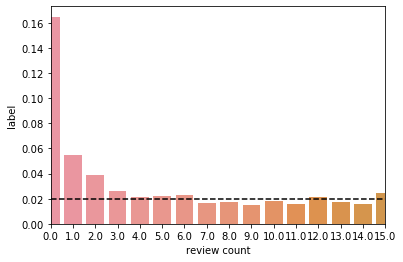

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train_grouped = train_df.groupby(['review count'], as_index=False).agg({'label': 'mean'})
sns.barplot(x='review count', y='label', data=train_grouped)
plt.plot([0, 15], [0.02, 0.02], 'k--')  # dashed line at 2%
plt.xlim([0, 15])

In [12]:
# simple heuristics classifier

def heuristic_baseline(x):
    return (x['review count'] <= 2).astype(int)

heuristic_train = heuristic_baseline(train_df)
heuristic_dev = heuristic_baseline(dev_df)

In [13]:
from sklearn.metrics import average_precision_score, roc_auc_score

In [14]:
heuristic_train_auc = roc_auc_score(train_labels, heuristic_train)
heuristic_dev_auc = roc_auc_score(dev_labels, heuristic_dev)
heuristic_train_ap = average_precision_score(train_labels, heuristic_train)
heuristic_dev_ap = average_precision_score(dev_labels, heuristic_dev)

print('Simple heuristic baseline')
print(f'Train AUC: {heuristic_train_auc:.4f}\n'
      f'Dev   AUC: {heuristic_dev_auc:.4f}\n'
      f'Train AP:  {heuristic_train_ap:.4f}\n'
      f'Dev   AP:  {heuristic_dev_ap:.4f}')

Simple heuristic baseline
Train AUC: 0.6218
Dev   AUC: 0.6235
Train AP:  0.1321
Dev   AP:  0.1310


## NB Classifier

In [15]:
from sklearn.naive_bayes import MultinomialNB

In [16]:
nb = MultinomialNB()  # standard laplace smoothing is fine
nb.fit(train, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
nb_train = nb.predict(train)
nb_dev = nb.predict(dev)

In [18]:
nb_train_auc = roc_auc_score(train_labels, nb_train)
nb_dev_auc = roc_auc_score(dev_labels, nb_dev)
nb_train_ap = average_precision_score(train_labels, nb_train)
nb_dev_ap = average_precision_score(dev_labels, nb_dev)

print('NB baseline')
print(f'Train AUC: {nb_train_auc:.4f}\n'
      f'Dev   AUC: {nb_dev_auc:.4f}\n'
      f'Train AP:  {nb_train_ap:.4f}\n'
      f'Dev   AP:  {nb_dev_ap:.4f}')

NB baseline
Train AUC: 0.6106
Dev   AUC: 0.5015
Train AP:  0.3008
Dev   AP:  0.1040


In [19]:
# higher is better:
average_precision_score(train_labels, train_labels)

1.0

## RF Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
# i would like to finish training someday soon
rf = RandomForestClassifier(n_estimators=48,
                            random_state=0,
                            n_jobs=-1,
                            max_features='log2',
                            verbose=1,
                            max_depth=2000,
                            )

rf.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.9min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2000, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=48, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [39]:
rf_train = rf.predict(train)
rf_dev = rf.predict(dev)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 out of  48 | elapsed:   37.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 out of  48 | elapsed:    6.1s finished


In [40]:
rf_train_auc = roc_auc_score(train_labels, rf_train)
rf_dev_auc = roc_auc_score(dev_labels, rf_dev)
rf_train_ap = average_precision_score(train_labels, rf_train)
rf_dev_ap = average_precision_score(dev_labels, rf_dev)

print('RF baseline')
print(f'Train AUC: {rf_train_auc:.4f}\n'
      f'Dev   AUC: {rf_dev_auc:.4f}\n'
      f'Train AP:  {rf_train_ap:.4f}\n'
      f'Dev   AP:  {rf_dev_ap:.4f}')

RF baseline
Train AUC: 0.5023
Dev   AUC: 0.5000
Train AP:  0.1071
Dev   AP:  0.1016
